1. Install Dependencies

In [ ]:
import tensorflow as tf
import os
import keras
from tensorflow.keras import layers

2. Remove dodgy images

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir = '/content/drive/MyDrive/CS/Capstone/data' 

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
#making sure image exists in image directory
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

3. Load data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/CS/Capstone/data')

Found 3297 files belonging to 2 classes.


In [ ]:
#iterator
data_iterator = data.as_numpy_iterator()

In [ ]:
#1 batch is ~30 imgs from keras utils
batch = data_iterator.next()

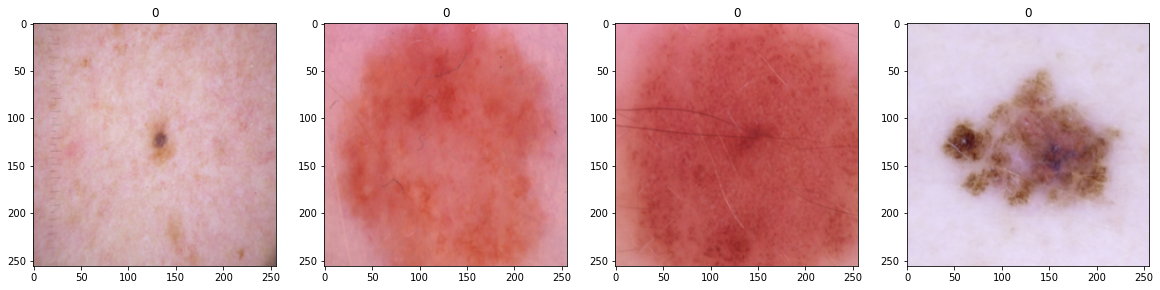

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [ ]:
#scaling data to be from 0 to 1
#x: img data, y: whether malignant or benign
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
data.as_numpy_iterator().next()

(array([[[[0.6392157 , 0.46666667, 0.4627451 ],
          [0.6392157 , 0.4730392 , 0.47549018],
          [0.6526961 , 0.4879902 , 0.49460784],
          ...,
          [0.73088235, 0.5862745 , 0.6073529 ],
          [0.7247549 , 0.5647059 , 0.5781863 ],
          [0.72156864, 0.5647059 , 0.5686275 ]],
 
         [[0.6392157 , 0.46029413, 0.4659314 ],
          [0.6418045 , 0.4744332 , 0.4812653 ],
          [0.65150124, 0.48679534, 0.4944087 ],
          ...,
          [0.72550553, 0.57850796, 0.5987898 ],
          [0.7239583 , 0.569087  , 0.57480085],
          [0.73112744, 0.5742647 , 0.5781863 ]],
 
         [[0.64191175, 0.45882353, 0.47745097],
          [0.64509803, 0.47037378, 0.48242953],
          [0.65392154, 0.482981  , 0.48981312],
          ...,
          [0.7271293 , 0.59221816, 0.6111366 ],
          [0.71905637, 0.5781863 , 0.58867955],
          [0.7198529 , 0.58455884, 0.5884804 ]],
 
         ...,
 
         [[0.65588236, 0.49485293, 0.5117647 ],
          [0.65608

5. Split data

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
train_size

72

In [ ]:
#takes the batches and inputs it in the train, validation, and test
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

6. Build Deep Learning Model
** Potentially replace w other dnn (https://viso.ai/deep-learning/resnet-residual-neural-network/)

In [ ]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization


In [ ]:
from keras.layers import Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

7. Train

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.7)

In [ ]:
logdir='/content/drive/MyDrive/CS/Capstone/logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

In [ ]:
hist = model.fit(train, epochs=100, validation_data=val, callbacks=[tensorboard_callback, red_lr])

Epoch 1/100
72/72 [==============================] - 25s 250ms/step - loss: 0.8543 - accuracy: 0.5365 - val_loss: 0.6615 - val_accuracy: 0.6953 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - 18s 236ms/step - loss: 0.5862 - accuracy: 0.6606 - val_loss: 0.5950 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - 18s 249ms/step - loss: 0.4761 - accuracy: 0.7582 - val_loss: 0.5088 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 4/100
72/72 [==============================] - 20s 270ms/step - loss: 0.4307 - accuracy: 0.7773 - val_loss: 0.5137 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/100
72/72 [==============================] - 19s 248ms/step - loss: 0.4231 - accuracy: 0.7830 - val_loss: 0.4966 - val_accuracy: 0.7922 - lr: 0.0010
Epoch 6/100
72/72 [==============================] - 20s 269ms/step - loss: 0.4002 - accuracy: 0.7964 - val_loss: 0.5435 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 7/100
72/72 [==============================] - ETA: 

8. Plot Performance

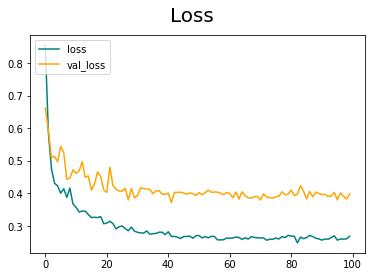

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show() 

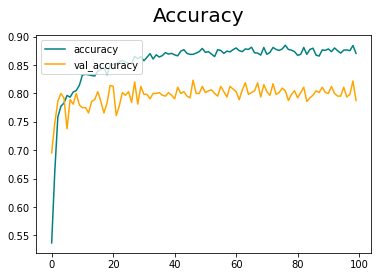

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 36ms/step


In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.74556214, shape=(), dtype=float32) tf.Tensor(0.8873239, shape=(), dtype=float32) tf.Tensor(0.815625, shape=(), dtype=float32)


10. Test

In [ ]:
import cv2

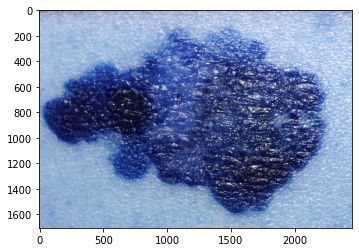

In [ ]:
img = cv2.imread('/content/drive/MyDrive/CS/Capstone/Melanoma.jpg')
plt.imshow(img)
plt.show()

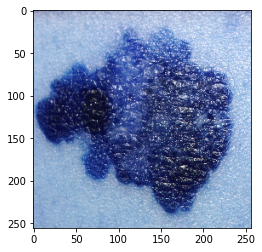

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

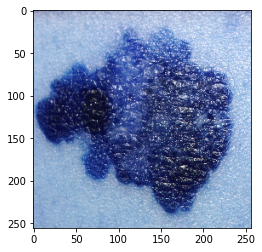

In [ ]:
test = plt.imshow(resize.numpy().astype(int))


In [ ]:
resize

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[ 74.22191 ,  92.45861 , 155.22815 ],
        [ 97.93135 , 113.49443 , 167.6794  ],
        [107.11685 , 118.66169 , 165.47818 ],
        ...,
        [146.2539  , 155.10547 , 195.10547 ],
        [143.50562 , 157.32617 , 194.86636 ],
        [194.37027 , 193.71011 , 227.71011 ]],

       [[115.31221 , 122.90122 , 171.98604 ],
        [125.909615, 139.36523 , 173.2182  ],
        [135.0969  , 146.02124 , 185.04077 ],
        ...,
        [141.40039 , 157.14844 , 201.70312 ],
        [152.18521 , 165.89008 , 205.10547 ],
        [168.48746 , 180.6543  , 217.0187  ]],

       [[120.36507 , 137.15039 , 178.75772 ],
        [141.04517 , 147.74438 , 180.48709 ],
        [141.57617 , 147.81488 , 180.5558  ],
        ...,
        [127.47043 , 149.29771 , 197.29771 ],
        [144.81691 , 164.11938 , 202.5647  ],
        [144.13077 , 164.03337 , 199.75407 ]],

       ...,

       [[137.14453 , 164.92986 , 201.92986 ],
        [141.

In [ ]:
#y prediction
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 167ms/step


In [ ]:
yhat

array([[0.67234725]], dtype=float32)

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Malignant')
else:
    print(f'Predicted class is Benign')

Predicted class is Malignant


11. Save the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/CS/Capstone/models','imageclassifier.h5'))

In [ ]:
new_model = load_model('/content/drive/MyDrive/CS/Capstone/models/imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 124ms/step


array([[0.67234725]], dtype=float32)